In [13]:
import matplotlib.pyplot as plt
from aerobot.io import RESULTS_PATH, load_results_dict, DATA_PATH
from aerobot.plot import plot_configure_mpl, PRETTY_NAMES
from aerobot.contigs import KMER_FEATURE_TYPES, contigs_get_genome_size
import pandas as pd
from matplotlib.gridspec import GridSpec
from scipy.stats import linregress
import numpy as np
import os
from typing import List, Dict, Tuple
import scipy.optimize
import glob 

%load_ext autoreload 
%autoreload 2 

plot_configure_mpl(figure_height=2) # Want at least one color for each genome have results for. 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
CONTIGS_PATH = os.path.join(DATA_PATH, 'contigs')
# These are the feature types which I currently have results for. 
feature_types = ['aa_1mer', 'aa_2mer', 'aa_3mer']

In [15]:
# Want to get the final model accuracies for adding to the titles. 
val_accs = dict()
for feature_type in feature_types:
    results = load_results_dict(os.path.join(RESULTS_PATH, f'train_nonlinear_{feature_type}_ternary.json'))
    val_acc = results['validation_acc']
    print(f'Final validation accuracy for {feature_type}: {val_acc}')
    val_accs[feature_type] = int(val_acc * 100)

Final validation accuracy for aa_1mer: 0.7316310551315467
Final validation accuracy for aa_2mer: 0.810893344488887
Final validation accuracy for aa_3mer: 0.8057874242731667


In [16]:
# Load the correct labels for each genome. 
genome_labels_df = pd.read_csv(os.path.join(CONTIGS_PATH, 'genomes.csv'), index_col=0)
# Organize the contigs results into DataFrames for plotting. 
contigs_results = dict() 

for feature_type in feature_types:
    predictions_df = pd.read_csv(os.path.join(RESULTS_PATH, f'predict_contigs_{feature_type}.csv')).set_index('genome_id')
    predictions_df = predictions_df.merge(genome_labels_df, how='left', left_index=True, right_index=True)
    # We want to assess contig predictions based on the whole-genome predictions. 
    genome_predictions_df = predictions_df[predictions_df.contig_size == 0][['prediction']]
    genome_predictions_df = genome_predictions_df.rename(columns={'prediction':'genome_prediction'})
    predictions_df = predictions_df.merge(genome_predictions_df, how='left', left_index=True, right_index=True)
    # "correct" column indicates whether or not the contig prediction matches the genome prediction. 
    predictions_df['correct'] = predictions_df.genome_prediction == predictions_df.prediction
    contigs_results[feature_type] = predictions_df

genome_counts = predictions_df[~predictions_df.index.duplicated(keep='first')].label.value_counts()
print('Number of aerobe genomes:', genome_counts['aerobe'])
print('Number of anaerobe genomes:', genome_counts['anaerobe'])
print('Number of facultative genomes:', genome_counts['facultative'])


Number of aerobe genomes: 66
Number of anaerobe genomes: 48
Number of facultative genomes: 21


# SI Figure 6


In [25]:
def plot_si_figure_6(contigs_results:Dict[str, pd.DataFrame], fig:plt.Figure=None, grids:List[GridSpec]=None):
    '''Plot the results of evaluating trained Nonlinear classifiers on contigs. The contigs are generated using closed
    genomes from the testing dataset, for which we have known labels.'''
    axes = []
    for i, feature_type in enumerate(feature_types):
        ax = fig.add_subplot(grids[i])

        # Extract the results for the specified feature type. 
        results = contigs_results[feature_type]
        
        labels, handles = [],[]
        # Group the results according to the true label of the genome...
        for label, label_df in results.groupby('label'):
            labels.append(label)
            
            x_vals, y_vals = [], []
            for contig_size, contig_size_df in label_df.groupby('contig_size'):
                # The genome prediction is stored under contig_size 0. 
                if contig_size > 0: 
                    x_vals.append(contig_size)
                    y_vals.append(contig_size_df.correct.mean())

            handles.append(ax.scatter(x_vals, y_vals, s=10, edgecolors='k', linewidths=0.2))
            
        ax.set_xlabel('contig size')
        ax.set_yticks(np.arange(0.2, 1.0, 0.1), labels=[str(np.round(i, 2)) for i in np.arange(0.2, 1.0, 0.1)]) # Make tick labels consistent across plots.
        ax.set_ylabel('fraction matching genome prediction')
        ax.set_title(PRETTY_NAMES[feature_type] + f' ({val_accs[feature_type]}%)')
        axes.append(ax)
    
    axes[0].legend(handles=handles, labels=labels, loc='lower right')
        
    return axes # Return the axes for plotting the A, B, C labels. 



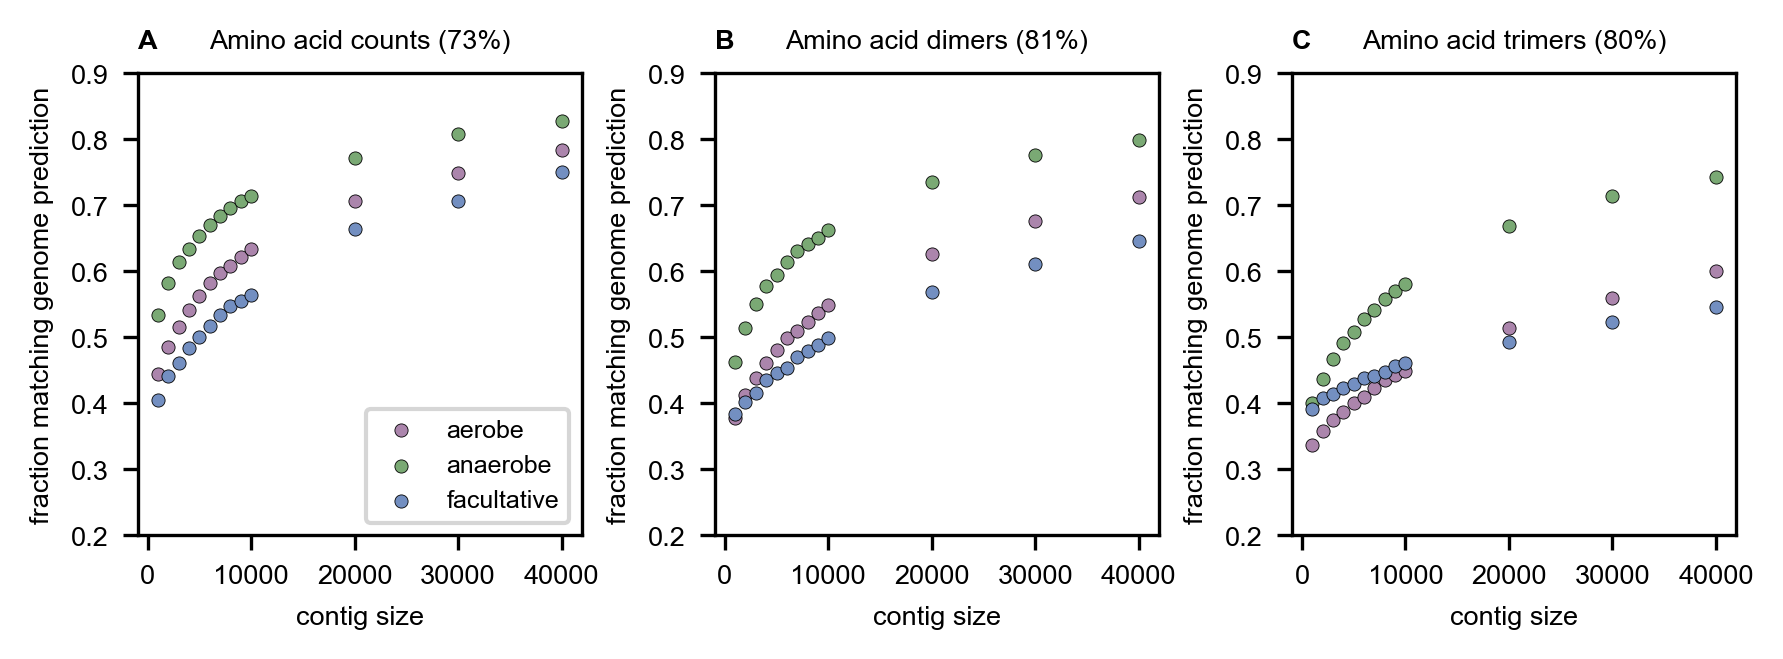

In [26]:
# n_rows, n_cols = 2, 3
n_cols = 3
fig = plt.figure()

grids = GridSpec(1, n_cols, wspace=0.3)
grids = [grids[0, i] for i in range(n_cols)] # + [grids[1, i] for i in range(n_cols)]

axes = plot_si_figure_6(contigs_results, fig=fig, grids=grids)

for ax, ax_label in zip(axes, 'ABC'):
    ax.set_title(ax_label, loc='left', fontweight='bold')

plt.savefig('../results/figures/si_fig7.png', dpi=300, facecolor='w', bbox_inches='tight')
plt.show()